In [1]:
import scipy as sp
import numpy as np
import seaborn as sbn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Columns: 133 entries, nAcid to pValue
dtypes: float64(133)
memory usage: 4.2 MB


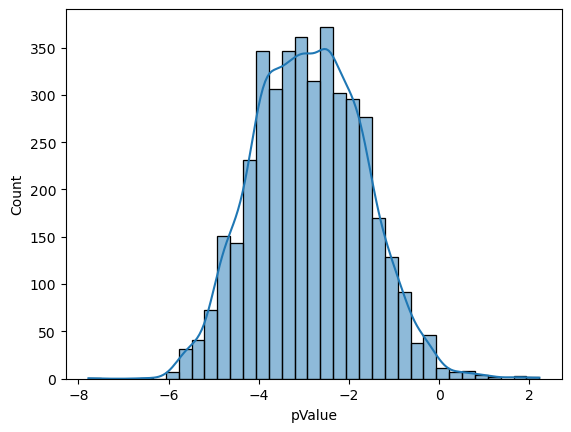

In [2]:
# Данные

data = pd.read_csv('2task_res.csv')

# Рассчет p-value IC-50

data.loc[:, 'pValue'] = -np.log10(data['standard_value'])

# Гистограмма распределения

sbn.histplot(data, x="pValue", kde=True, bins=35)
plt.savefig('Histogram.png') # В целом, данные соответствуют нормальному распределению

# Выкидываем из датасета уже ненужные строки smiles и standard_value

data = data.iloc[:, 2:]

# Стандартизация

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)


with open('Prep_data.csv', 'w', newline='', encoding='utf-8'):
    scaled_data.to_csv('Prep_data.csv', index = False)

scaled_data.info()


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import mean_absolute_error, make_scorer
import optuna
import joblib as jbl

seed = 42

In [4]:
# Формирование обучающей выборки

y = scaled_data['pValue'].values
x = scaled_data.drop(columns = ['pValue']).copy()
x = x.astype('Float32')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True)

In [ ]:
# Random Forest Regressor

def rmf_param_randomising(n):
    params = {'n_estimators' : n.suggest_int('n_estimators', 100, 400),
              'max_depth': n.suggest_int('max_depth', 3, 10), 
              'min_samples_split' : n.suggest_int('min_samples_split', 2, 5),
              'min_samples_leaf': n.suggest_int('min_samples_leaf', 1, 5),
              'random_state' : seed,
              'n_jobs': -1}
    model = RandomForestRegressor(**params)
    mae = make_scorer(mean_absolute_error, greater_is_better = False)
    y_bins = pd.qcut(y_train, q = 10, duplicates = 'drop', labels = False)
    cv = list(StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed).split(x_train, y_bins))
    score = cross_val_score(model, x_train, y_train, cv = 10, scoring = mae, n_jobs = -1)
    return score.mean()

study = optuna.create_study(direction = 'minimize')
study.optimize(rmf_param_randomising, n_trials = 40)

best_params = study.best_params

print("Лучшие параметры:")
print(best_params)

model_final = RandomForestRegressor(**best_params)
model_final.fit(x_train, y_train)

jbl.dump(model_final, 'RandomForestRegressor_model.joblib')

[I 2025-07-11 17:46:05,648] A new study created in memory with name: no-name-f4290b56-10c1-4218-9762-caf7a93b3722
[I 2025-07-11 17:46:38,954] Trial 0 finished with value: -0.6016366164132796 and parameters: {'n_estimators': 106, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: -0.6016366164132796.
[I 2025-07-11 17:47:38,801] Trial 1 finished with value: -0.5797937963957133 and parameters: {'n_estimators': 184, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: -0.6016366164132796.
[I 2025-07-11 17:49:15,786] Trial 2 finished with value: -0.5768250484870304 and parameters: {'n_estimators': 274, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: -0.6016366164132796.
[I 2025-07-11 17:50:54,724] Trial 3 finished with value: -0.6013459885135684 and parameters: {'n_estimators': 348, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with 

Лучшие параметры:
{'n_estimators': 108, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}


['RandomForestRegressor_model.joblib']

In [ ]:
# Stochastic Gradient Descent

def sdg_param_randomising(n):
    params = {'max_iter' : n.suggest_int('max_iter', 100, 1500),
              'alpha': n.suggest_float('alpha', 1e-4, 1e-3, log=True),
              'eta0': n.suggest_float('eta0', 1e-4, 1e-3, log=True),
              'penalty' : n.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
              'loss' : 'squared_error',
              'random_state' : seed}
    model = SGDRegressor(**params)
    y_bins = pd.qcut(y_train, q = 10, duplicates = 'drop', labels = False)
    cv = list(StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed).split(x_train, y_bins))
    score = cross_val_score(model, x_train, y_train, cv = 10, scoring = 'neg_mean_squared_error', n_jobs = -1)
    return score.mean()
    
study = optuna.create_study(direction = 'maximize')
study.optimize(sdg_param_randomising, n_trials = 250)

best_params = study.best_params

print("Лучшие параметры:")
print(best_params)

model_final = SGDRegressor(**best_params)
model_final.fit(x_train, y_train)

jbl.dump(model_final, 'SGDRegressor_model.joblib')

[I 2025-07-11 20:07:00,664] A new study created in memory with name: no-name-26656b64-3449-4f24-a208-1fbaa08fc905
[I 2025-07-11 20:07:02,669] Trial 0 finished with value: -0.8197945499715299 and parameters: {'max_iter': 654, 'alpha': 0.000540970696067675, 'eta0': 0.0006677879211793342, 'penalty': 'l1'}. Best is trial 0 with value: -0.8197945499715299.
[I 2025-07-11 20:07:02,919] Trial 1 finished with value: -0.8147311313023667 and parameters: {'max_iter': 1496, 'alpha': 0.0005515700502898008, 'eta0': 0.0009528140681935367, 'penalty': 'elasticnet'}. Best is trial 1 with value: -0.8147311313023667.
[I 2025-07-11 20:07:03,139] Trial 2 finished with value: -0.8313982609829991 and parameters: {'max_iter': 592, 'alpha': 0.00046699024467576145, 'eta0': 0.00023147376154026994, 'penalty': 'l2'}. Best is trial 1 with value: -0.8147311313023667.
[I 2025-07-11 20:07:03,388] Trial 3 finished with value: -0.8424352366191009 and parameters: {'max_iter': 542, 'alpha': 0.0001266649104470776, 'eta0': 0.

Лучшие параметры:
{'max_iter': 517, 'alpha': 0.00010768723522162756, 'eta0': 0.000999991091211301, 'penalty': 'l2'}


['SGDRegressor_model.joblib']

In [6]:
import torch
from pytorch_lightning import seed_everything
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Настройки для RX 470

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '8.0.3'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

seed_everything(seed)

Seed set to 42


42

Epoch 1:   0%|          | 0/3289 [00:00<?, ?it/s]

/home/suunar/miniforge3/envs/jupyter/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/suunar/miniforge3/envs/jupyter/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 45: 100%|██████████| 3289/3289 [00:10<00:00, 326.50it/s]


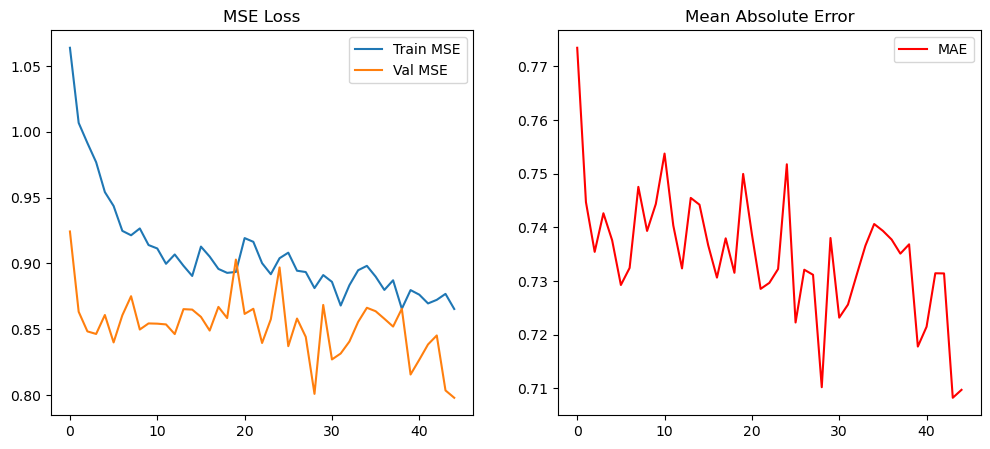

In [ ]:
# Формирование нейросети MLP (три скрытых слоя и дропауты, без бэтчинга)

class DeepMLP(nn.Module):
    def __init__(self, in_size, hid_size, out_size, dropout = 0.5):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_size, hid_size),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.LayerNorm(hid_size),

                                 nn.Linear(hid_size, hid_size // 2),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.LayerNorm(hid_size // 2),

                                 nn.Linear(hid_size // 2, hid_size // 4),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.LayerNorm(hid_size // 4),
                                 
                                 nn.Linear(hid_size // 4, hid_size // 8),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.LayerNorm(hid_size // 8),
                                 
                                 nn.Linear(hid_size // 8, hid_size // 16),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.LayerNorm(hid_size // 16),

                                 nn.Linear(hid_size // 16, out_size))

    def forward(self, x):
        return self.net(x)

device = torch.device('cpu')
model = DeepMLP(in_size = x_train.shape[1], hid_size = 132, out_size = 1).to(device)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train_tensor = torch.tensor(x_train.values)  #, dtype = torch.float32
y_train_tensor = torch.from_numpy(y_train)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
x_test_tensor = torch.tensor(x_test.values)
y_test_tensor = torch.from_numpy(y_test)       #, dtype = torch.float32

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loaded = DataLoader(train_dataset, batch_size = 1, shuffle = True, num_workers = 0, pin_memory = True, drop_last = True)
test_loaded = DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 0, pin_memory = True, drop_last = True)

criterion = nn.MSELoss()  # MSE для регрессии
optimizer = optim.Adam(model.parameters(), lr = 0.001)

history = {'train_loss': [], 'val_loss': [], 'mae' : []}
best_val_acc = 0.0

num_epochs = 45

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loaded, desc=f'Epoch {epoch+1}'):
        inputs = inputs.to(device)
        labels = labels.float().to(device)  # Метки как float для регрессии
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loaded)
    
    # Валидация

    model.eval()
    val_loss = 0.0
    total_mae = 0.0
    best_loss = np.inf
    with torch.no_grad():
        for inputs, labels in test_loaded:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            total_mae += torch.abs(outputs - labels).sum().item()
    
    val_loss /= len(test_loaded)
    mae = total_mae / len(test_loaded.dataset)  # Средняя абсолютная ошибка

    # Сохранение лучшей модели

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_regressor.pth')

    # Логирование
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['mae'].append(mae)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train MSE')
plt.plot(history['val_loss'], label='Val MSE')
plt.legend()
plt.title('MSE Loss')

plt.subplot(1, 2, 2)
plt.plot(history['mae'], color='red', label='MAE')
plt.legend()
plt.title('Mean Absolute Error')
plt.savefig('Res_MLPRegression.png')